In [144]:
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt

In [1]:
title = "# Introduction to Bayesian statistics"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Introduction to Bayesian statistics

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

In Bayesian statistics we want to infer the probability distribution of some unobserved parameters $\theta$, given some data $d$. 

That is, we want to infer the *posterior* probability distribution $p(\theta | d)$. It is called posterior, because it describes the probability of $\theta$ *after* we have observed the data.

Using Bayes' theorem, we can write the posterior as
$$
    p(\theta | d) = \frac{p(d | \theta)p(\theta)}{p(d)}
$$



The different terms in the right-hand side have specific terms for them:
- The likelihood $p(d | \theta)$ is the probability of the data $d$, given the parameters $\theta$
- The *prior* $p(\theta)$ is the probability of the parameters $\theta$ (in the sense of our degree of believe) *before* we observe the data $d$. 
- The evidence $p(d)$ (sometimes also called marginal likelihood) can often be treated as an overall normalisation factor and ignored. It becomes important for model comparison, however.

The power of Bayes' theorem comes from how it relates what we want to know (the probability of the parameters, given the data) to what we can calculate (the probability of the data, given the parameters).

Consider the case of an urn with $n$ balls, $r$ of which are red and $w$ of which are white. The question is then often along the lines of "what is the probability of getting 2 red balls in 5 drawings?"

In science, we are usually faced with a different problem: we have just drawn 2 red balls and 3 white ones and we want to know how many balls of each kind are in the urn.

Here Bayes comes to the rescue:
$$
    p(\text{content of urn}|\text{data}) \propto p(\text{data}|\text{content of urn})p(\text{content of urn})
$$

### Likelihood

The first term is the likelihood $p(\text{data}|\text{content of urn})$, which we can calculate.

Assuming that we are drawing with replacement, no clumping of the balls or other funny business, the probability of drawing a red ball is $\theta=\frac{r}{n}$.

We assume we know the total number of balls in the urn $n$.

The probability of drawing $k$ red balls in $t$ trials it is given by a binomial distribution:
$$
    p(k, t| r) = \binom{t}{k}\left(\frac{r}{n}\right)^k\left(1-\frac{r}{n}\right)^{t-k}
$$
Here the data are $k$ and $t$, the number of red balls we have drawn and the number of trials. 

The parameter is $r$, the number of red balls in the urn. 



### Prior

The second term is the prior $p(\text{content of urn})$, which we need to define. 

Assuming we have no prior information or other indication on how many of the balls are red, a reasonable assumption is that the number of red balls is equally likely between 0 and $n$:

$$
    p(r) = \frac{1}{n+1}
$$

### Posterior

What is the probability distribution of $r$, the number of red balls, given 2 red balls were drawn in 5 trials? I.e.
$$
    p(r | k=2, t=5)
$$

What is it when 20 red balls were drawn in 50 trials?

In [30]:
n = 10

def likelihood(k, t, r):
    theta = r/n
    return scipy.special.binom(t, k) * theta**k * (1-theta)**(t-k)

def prior(r):
    return 1/(n+1) * np.ones_like(r)

def posterior(r, k, t):
    return likelihood(k, t, r) * prior(r)


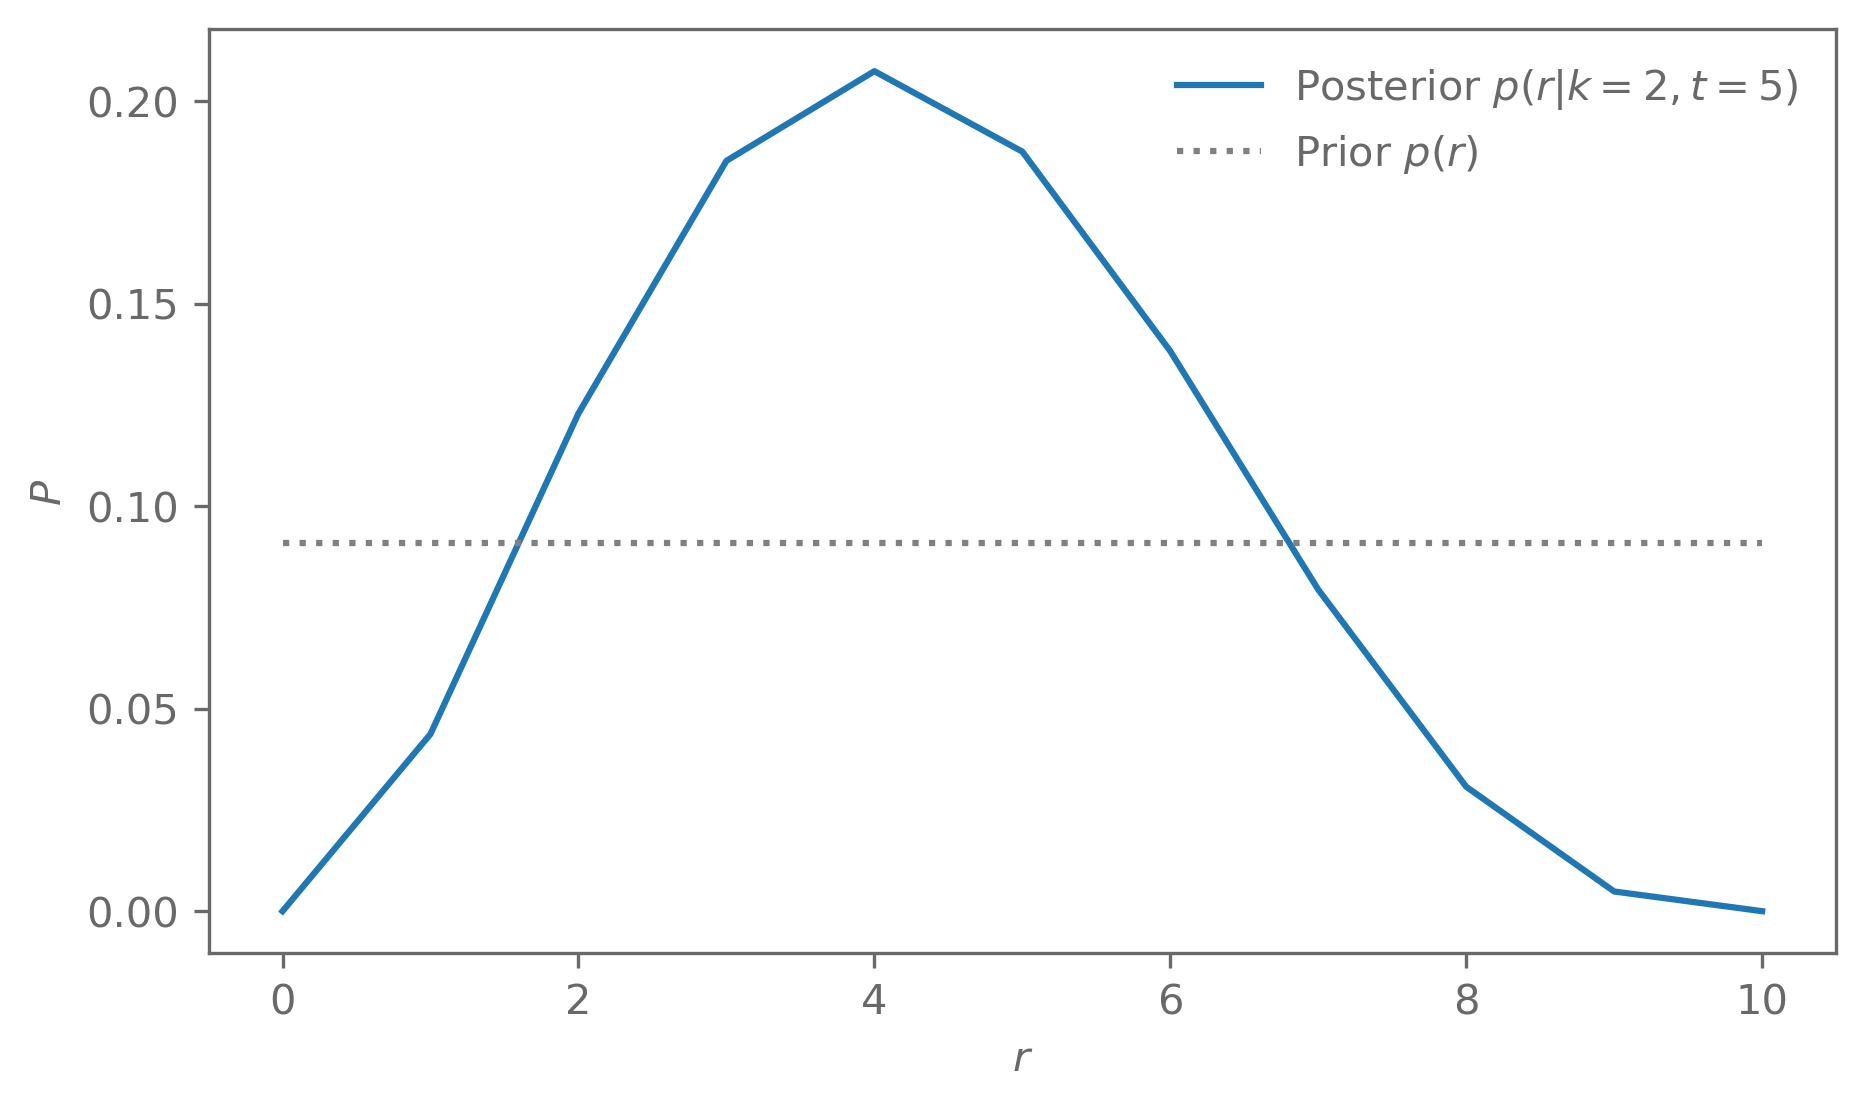

In [38]:
r = np.arange(0, n+1)

posterior_2_5 = posterior(r, k=2, t=5)
# Normalise the posterior
posterior_2_5 /= posterior_2_5.sum()

plt.plot(r, posterior_2_5, label="Posterior $p(r|k=2, t=5)$")
plt.plot(r, prior(r), c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");

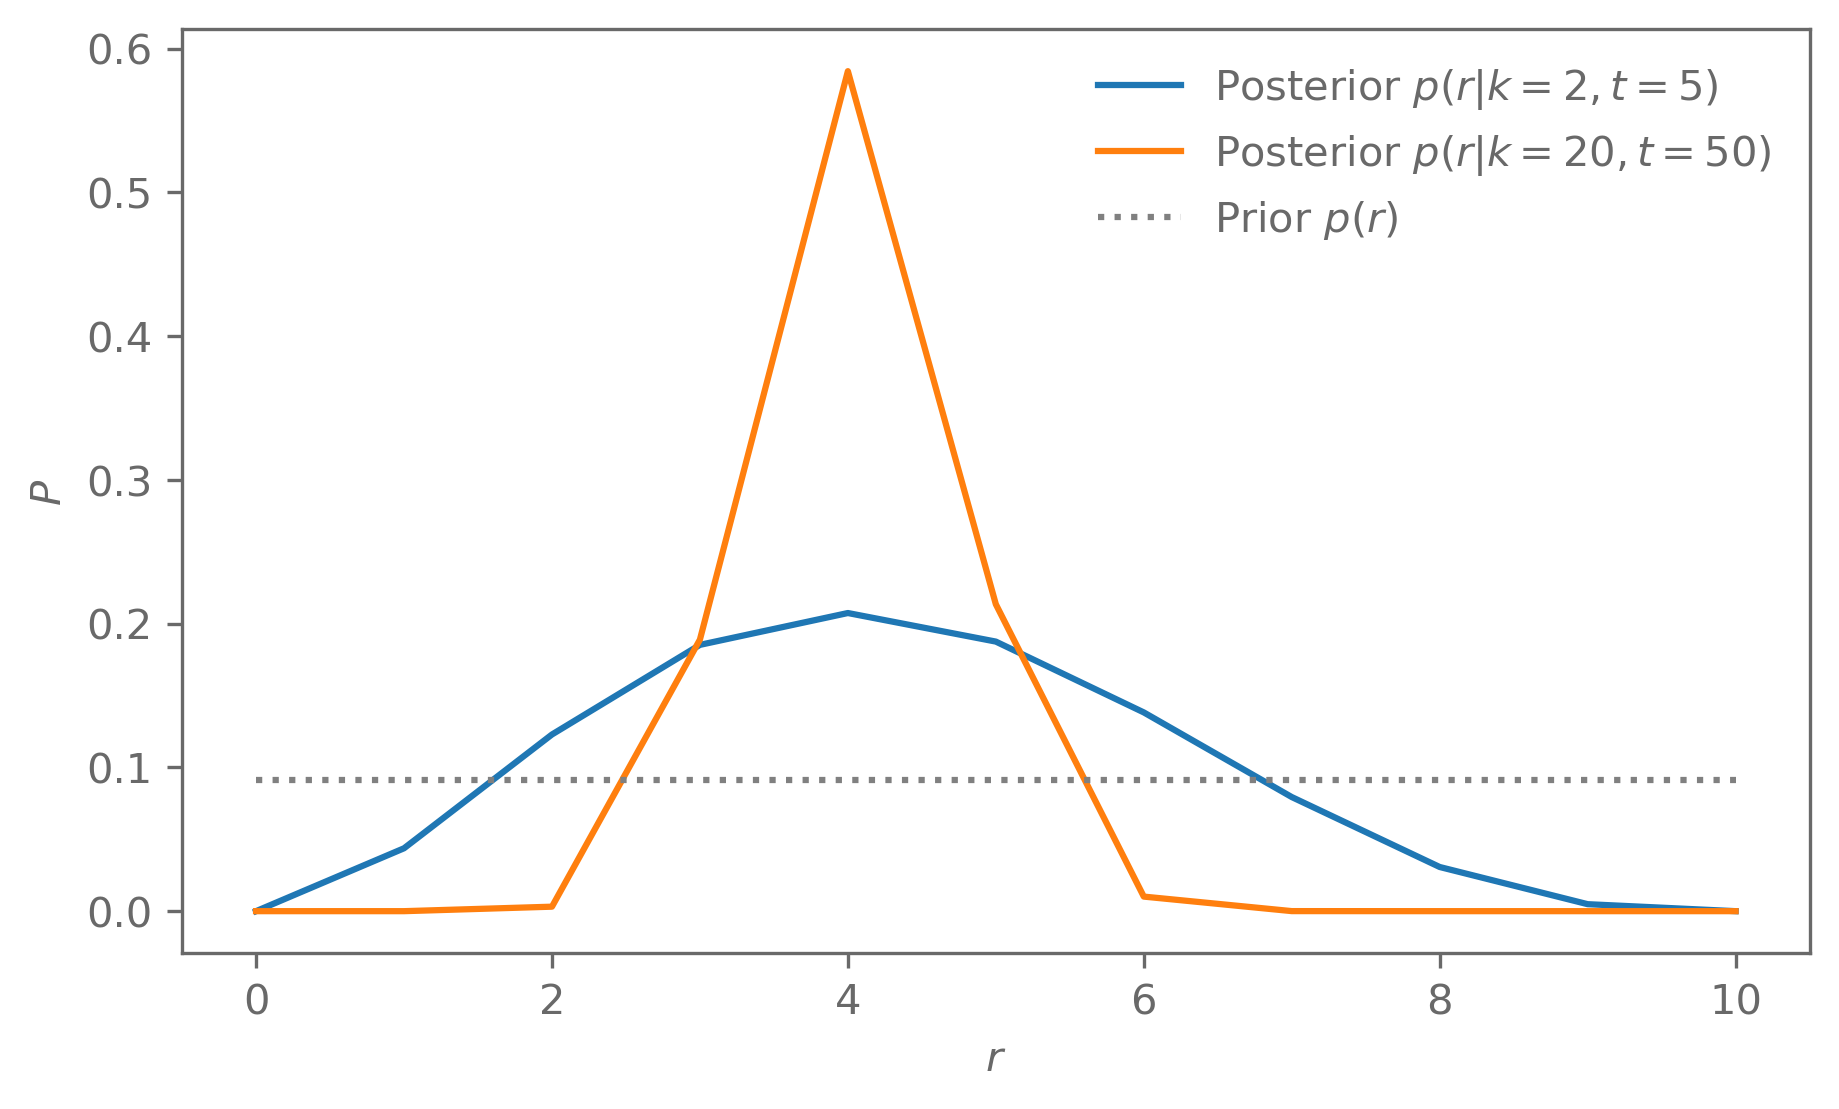

In [39]:
posterior_20_50 = posterior(r, k=20, t=50)
# Normalise the posterior
posterior_20_50 /= posterior_20_50.sum()

plt.plot(r, posterior_2_5, label="Posterior $p(r|k=2, t=5)$")
plt.plot(r, posterior_20_50, label="Posterior $p(r|k=20, t=50)$")
plt.plot(r, prior(r), c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");

### Updating the prior

The Bayesian formalism allows us to update our prior believes once new data comes in. 

Assume we have just finished the experiment where we drew 2 red balls in 5 trials.

If we now do a new experiment (using the same urn), we can use our knowledge from the previous experiment to update our prior on the number of red balls in the urn.

For example, we can use the posterior from the previous experiment as the prior.

What is the posterior on $r$ after the 2nd experiment where you draw $k=6$ red balls in $t=12$ trials, using the previous posterior distribution as the prior?

In [42]:
def updated_prior(r):
    return posterior(r, k=2, t=5)

def updated_posterior(r, k, t):
    return likelihood(k, t, r) * updated_prior(r)

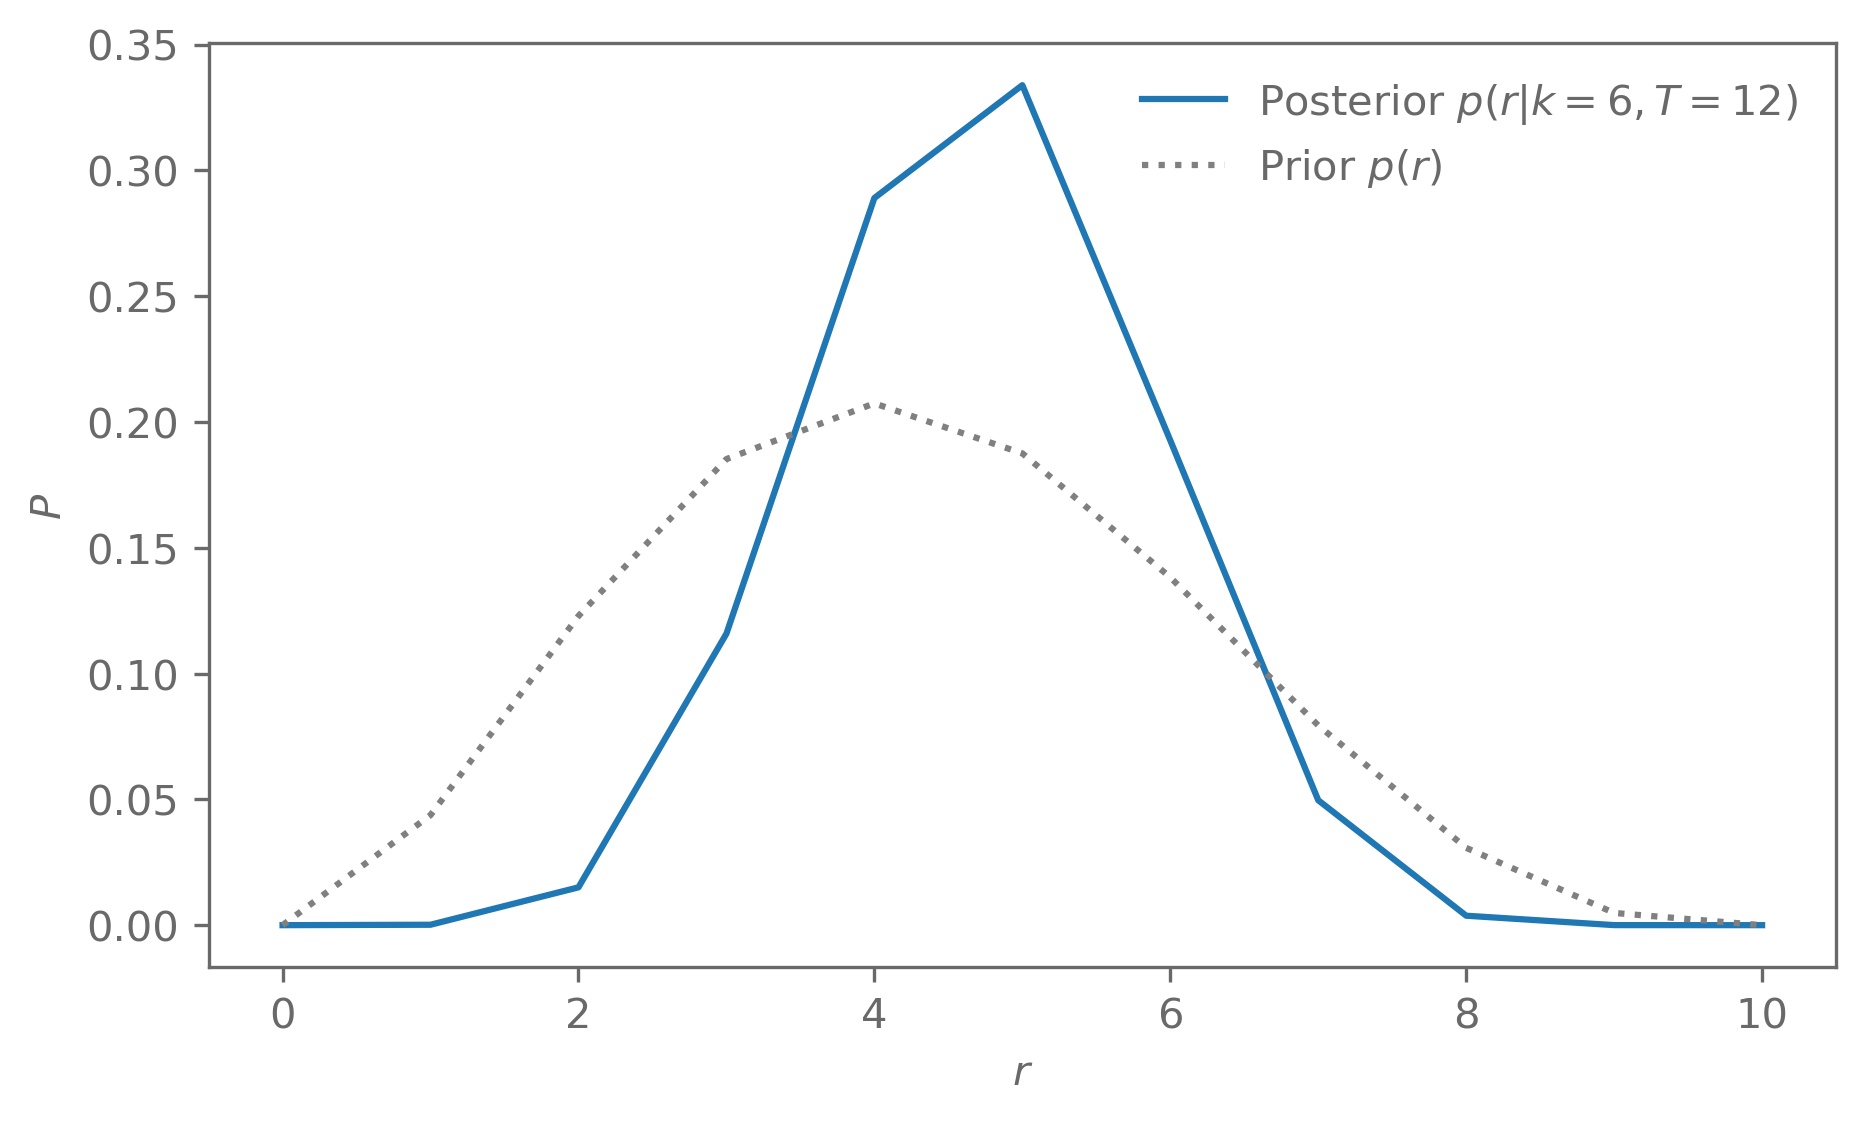

In [43]:
updated_posterior_5_12 = updated_posterior(r, k=6, t=12)
# Normalise
updated_posterior_5_12 /= np.sum(updated_posterior_5_12)

plt.plot(r, updated_posterior_5_12, label="Posterior $p(r|k=6, T=12)$")
plt.plot(r, posterior_2_5, c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");


## Making predictions

Because likelihood is a probability distribution of the data, we can can use it to sample new data given the model and parameters. 

Before the observed data are considered, the distribution of the data is
$$
    p(d) = \int p(d,\theta)\dd\theta = \int p(d|\theta)p(\theta)\dd\theta\ .
$$
In the context of making predictions, this is called the prior predictive distribution: 
- Prior, because it is not conditioned on the observed data
- Predictive, because it is the distribution of a quantity that is observable



It allows us to make predictions of how the observed data will look like under our prior, likelihood, and model. 
Comparing these predictions to the observed data can give us some indication if our priors, likelihoods, and models are reasonable.


As long as we can sample from the prior and from the likelihood, we can create samples from the prior predictive distribution by
1. Create samples $\theta_i$ form the prior
2. Sample new data from the likelihood, at parameter $\theta_i$: $\tilde d_i\sim p(\cdot | \theta_i)$

Our priors are usually simple enough the allow easy sampling. 
Because the likelihood describes the data generating process, we can almost always sample from it.

Even if we cannot evaluate the value of the likelihood, we can usually still sample from it.
- For example, a complex simulation of an experiment can simulate data but writing down a function for $p(d|\theta)$ is impossible

Once we have observed our actual data and found our posterior $p(\theta|d_\mathrm{obs})$, we can predict new data $\tilde d$, based on the data we just observed.

The posterior predictive distribution is

\begin{equation}
    \begin{split}
        p(\tilde d | d_\mathrm{obs}) &= \int p(\tilde d, \theta | d_\mathrm{obs})\dd \theta \\
        &= \int p(\tilde d | d_\mathrm{obs}, \theta)p(\theta|d_\mathrm{obs})\dd \theta \\
        &= \int p(\tilde d | \theta)p(\theta|d_\mathrm{obs})\dd \theta
    \end{split}
\end{equation}

We can sample from it similarly to the prior predictive distribution we saw before. Instead of sampling $\theta_i$ from the prior, we sample it from posterior $p(\theta | d_\mathrm{obs})$:
1. Create samples $\theta_i\sim p(\cdot | d_\mathrm{obs})$
2. Sample new data from the likelihood, at parameter $\theta_i$: $\tilde d_i\sim p(\cdot | \theta_i)$



The posterior predictive distribution comes in handy:
- Check that our model for the data actually agrees with the observed data. This is an important step in Bayesian analysis: the nicest posteriors on parameters are worthless if the parameters do not actually describe the data.
- Predict future observations: imaging we have some time-series data. Once we have conditioned our model on the observed data, we can predict how future data will look


Often we are in the situation where we have an underlying model $f(\theta)$ and the observed data scatter around this model, described by the likelihood.

For example, in a Gaussian likelihood with fixed variance $\sigma^2$, $f(\theta)$ would give the mean and the data would be distributed as $d\sim\Norm(f(\theta), \sigma^2)$.

In our analysis we might want to know the posterior distribution of the model $f(\theta)$, in addition to the distribution of just the parameters $\theta$.

The posterior distribution of the model is a variant of the prior and posterior predictive distributions and is sometimes called translated predictive distrution.

We sample from it by drawing samples $\theta_i$ from the posterior and evaluating the $f(\theta_i)$. 

This essentially corresponds to assuming a Dirac delta for the the likelihood.


## Model comparison

Suggested reading: Information Theory, Inference, and Learning Algorithms, chapter 28

So far we have assumed all the expressions implicitly assumed a model for how the parameters and data are connected. 

But what if there multiple plausible models? How do we choose among the models?



Bayesian statistics gives a clear answer to this. Let us first write out Bayes' theorem but now explicitly include that everything depends on the underlying model $M$:
$$
    p(\theta|d, M) = \frac{p(d|\theta, M)p(\theta|M)}{p(d|M)}\ .
$$
What we now want to know is the probability of the model $M$, given the data:
$$
    p(M|d) = p(d|M)p(M)
$$



If we have two models $M_1$ and $M_2$, we look at the ratio of their posteriors, called the Bayes' ratio:
$$
    \frac{p(M_1|d)}{p(M_2|d)} = \frac{p(d|M_1)}{p(d|M_2)}\frac{p(M_1)}{p(M_2)}
$$

The odds of model $M_1$ being true compared to model $M_2$ is given by the ratio of the evidences $\frac{p(d|M_1)}{p(d|M_2)}$ times the ratio of the priors of the models. 
If we assume both models to be equally like apriori, the Bayes ratio is just the ratio of the evidences.

Computing the evidence $p(d)$ is challenging in general. We will come back to this once we looked at nested sampling, which is a way to compute it.

## Fitting a line

To see how all these concepts work a bit more in practice, let us fit a line to some data.

Take a look at the data in `lessons/data/linear_fits/data_0.txt`

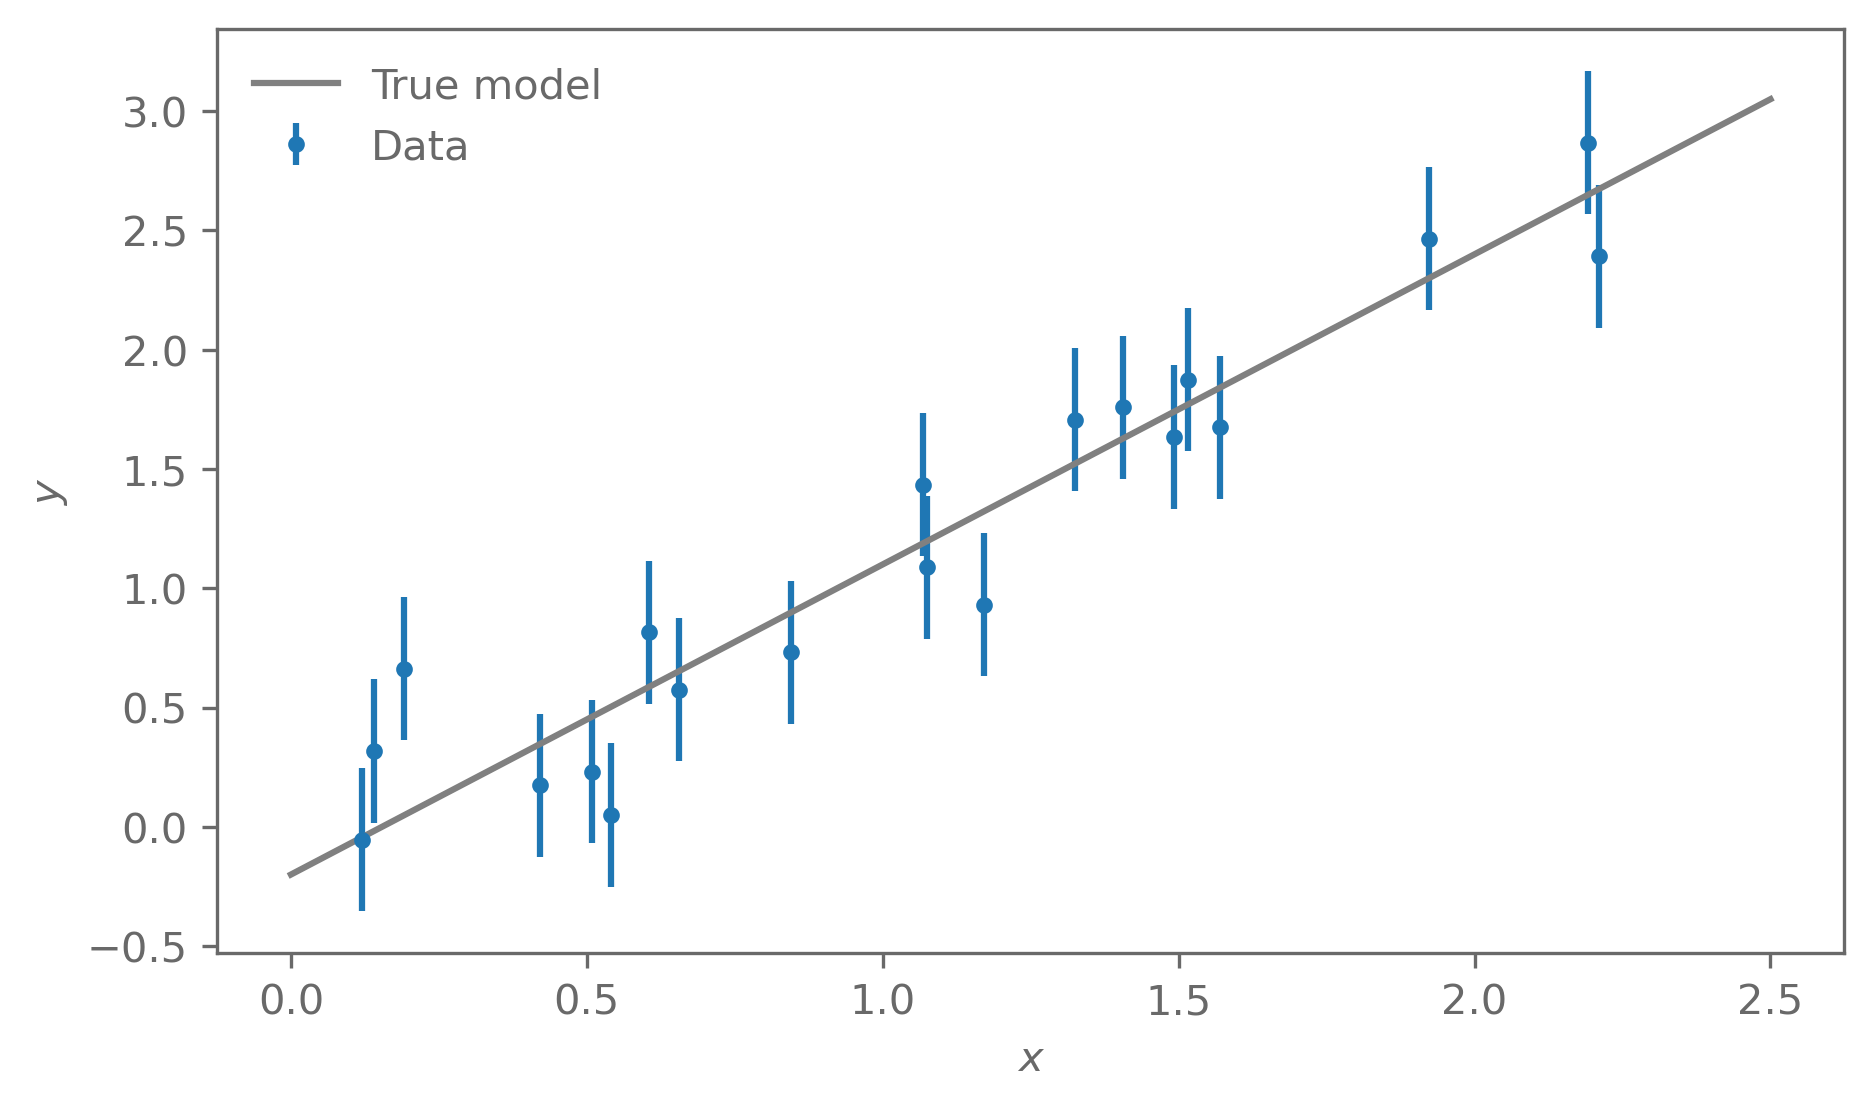

In [141]:
m_true = 1.3
b_true = -0.2

x, y, y_err = np.loadtxt("data/linear_fits/data_0.txt", unpack=True)
# For now, all error are the same
sigma_y = y_err[0]

plt.errorbar(x, y, y_err, fmt=".", label="Data")
x_grid = np.linspace(0, 2.5, 100)
plt.plot(x_grid, m_true*x_grid + b_true, c="grey", label="True model")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

Let us assume the following model for the data:

The data $y_i$ are Gaussian distributed around a linear model $f(x) = mx + b$, with a constant variance $\sigma_y^2$:

\begin{align}
    \mu(m, b, x) &= mx + b \\
    y_i&\sim\Norm\left(\mu(m, b, x_i),\sigma_y^2\right)
\end{align}


This lets us define the likelihood:

In [125]:
def model(m, b, x):
    return m*x + b

# We use the logarithm here for computational reasons
def log_likelihood(y, m, b, x, sigma_y):
    prediction = model(m, b, x)

    n = len(y)
    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)  # Exponent
        - n/2*np.log(2*np.pi*sigma_y**2)               # Normalisation
    )

We also need to define a prior. 

Let us assume that we have some prior knowledge:
- $m$ should be around 1 with uncertainty 1: $m\sim\Norm(1, 1)$
- $b$ should be around 0 with uncertainty 1.2: $b\sim\Norm(0, 1.2^2)$

In [148]:
def log_prior(m, b):
    mu_m = 1
    mu_b = 0

    sigma_m = 1
    sigma_b = 1.2

    return (
        -0.5*(m-mu_m)**2/sigma_m**2      # m exponent
        -0.5*(b-mu_b)**2/sigma_b**2      # b exponent
        - 0.5*np.log(2*np.pi*sigma_m**2) # Normalisation
        - 0.5*np.log(2*np.pi*sigma_b**2) # Normalisation
    )

Finally, the unnormalised posterior is the product of the two:

In [149]:
def log_posterior(m, b, x, sigma_y, y):
    return log_likelihood(y, m, b, x, sigma_y) + log_prior(m, b)

### MAP

We now defined our posterior, so we can start calculating things with it.

A first step might be to ask is, what is the most probable set of parameters $(m, b)$ that describe the data?

For this we need need to find the maximum of the posterior. This is called the maximum a-posteriori (MAP) and is the "best-fit" value:
$$
    \theta_\mathrm{MAP} = \mathrm{argmax}_\theta\ p(\theta|d)
$$

In [150]:
def negative_log_posterior(theta, x, sigma_y, y):
    m, b = theta
    return -log_posterior(m, b, x, sigma_y, y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(1, 0),
    args=(x, sigma_y, y)
)
m_MAP, b_MAP = MAP_result.x
print("MAP results")
print(f"m_MAP = {m_MAP:.3f}, b_MAP = {b_MAP:.3f}")
print(f"m_true = {m_true:.3f}, b_true = {b_true:.3f}")

MAP results
m_MAP = 1.251, b_MAP = -0.145
m_true = 1.300, b_true = -0.200


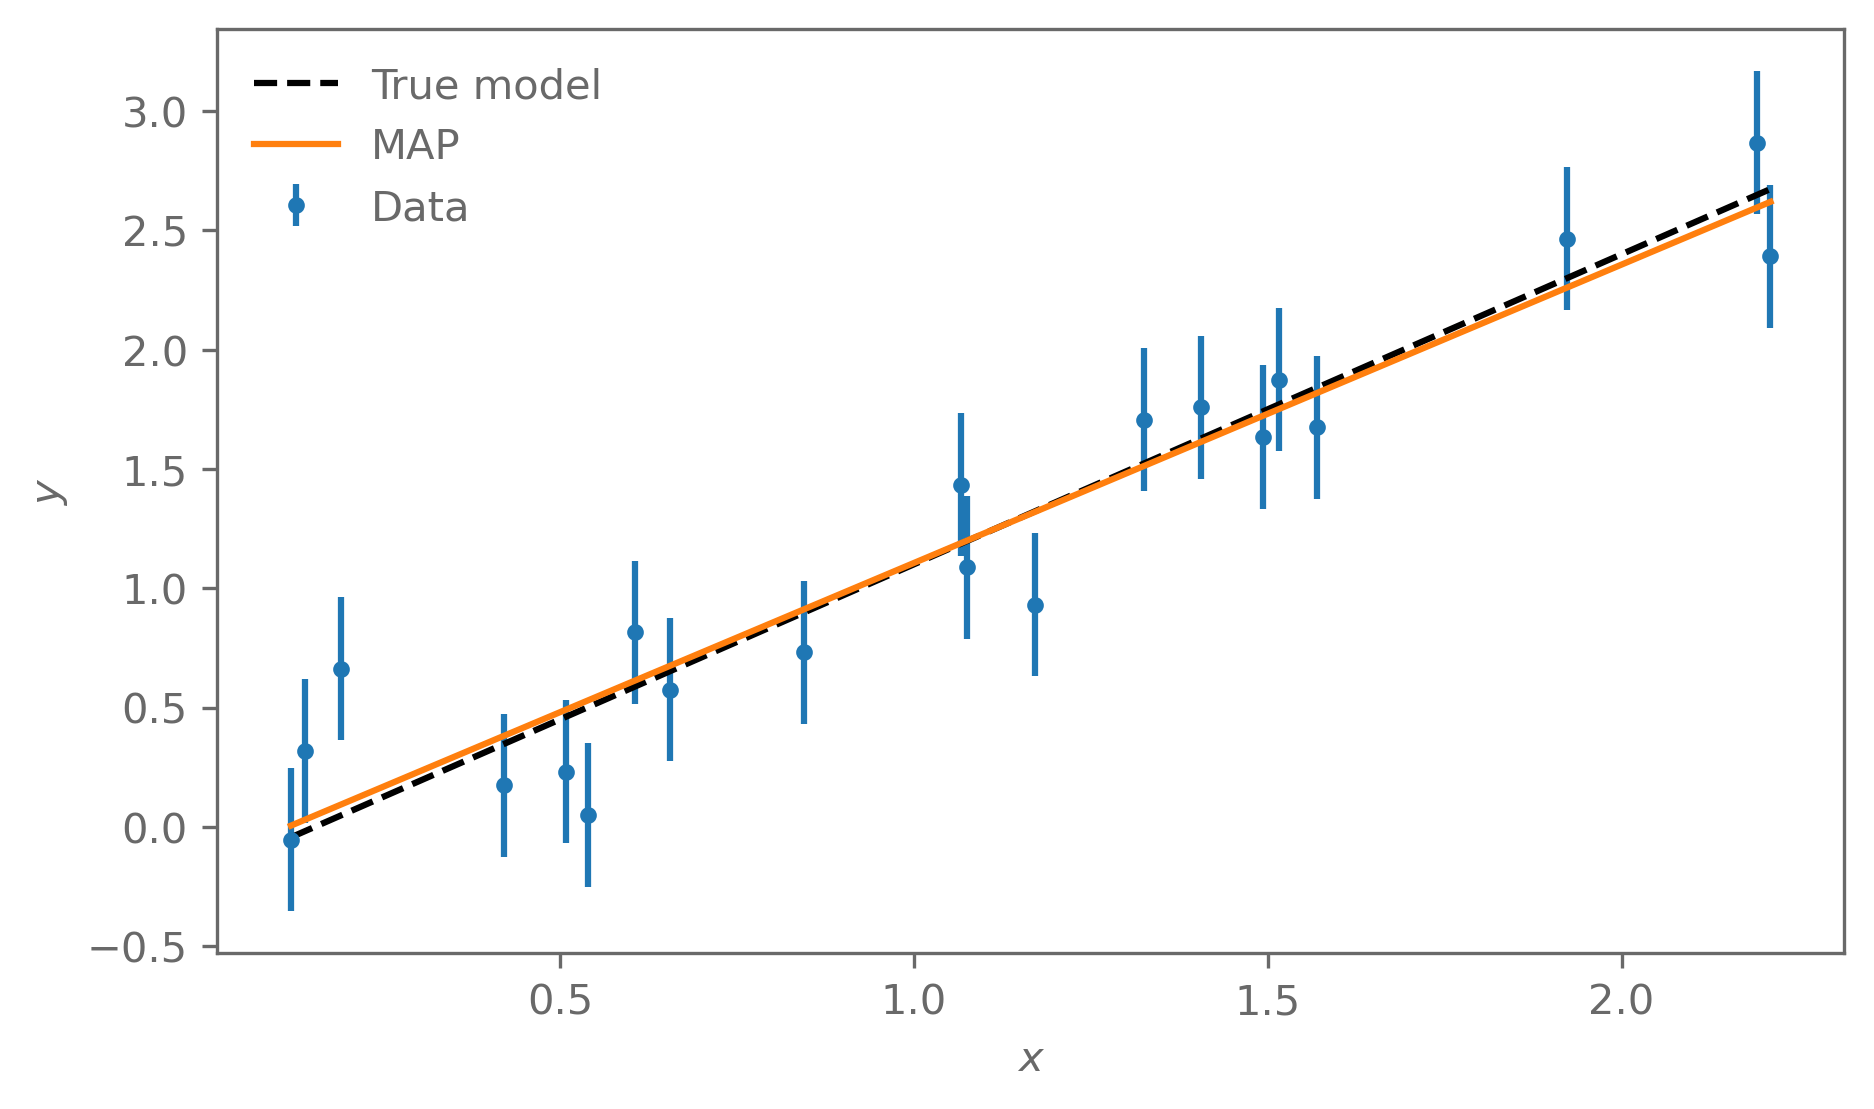

In [151]:
plt.errorbar(x, y, y_err, fmt=".", label="Data")
x_grid = np.linspace(0, 2.5, 100)
plt.plot(x, model(m_true, b_true, x), c="k", ls="--", label="True model")

plt.plot(x, model(m_MAP, b_MAP, x), c="C1", label="MAP model")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

## Sampling the posterior

The MAP only tells us about the mode of the posterior. 

In Bayesian statistics we care about the whole probability structure.

To get there, we need to create samples from the posterior. 

In this specific example there is an analytic expression for the posterior but in general that is not the case!

In [152]:
import emcee

def log_posterior_wrapper(theta, x, sigma_y, y):
    m, b = theta
    return log_posterior(m, b, x, sigma_y, y)

n_param = 2
n_walker = 10
n_step = 10000

theta_init = np.array([0.5, 0.5]) + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(nwalkers=n_walker, ndim=n_param, log_prob_fn=log_posterior_wrapper, args=(x, sigma_y, y))
state = sampler.run_mcmc(theta_init, nsteps=n_step)

In [156]:
import corner

print("Auto-correlation time:")
for name, value in zip(["m", "b", "f"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")

chain = sampler.get_chain(discard=300, thin=30, flat=True)

fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=["m", "b"],
    truths=[m_true, b_true],
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
);
plt.close()

Auto-correlation time:
m = 31.9
b = 34.8


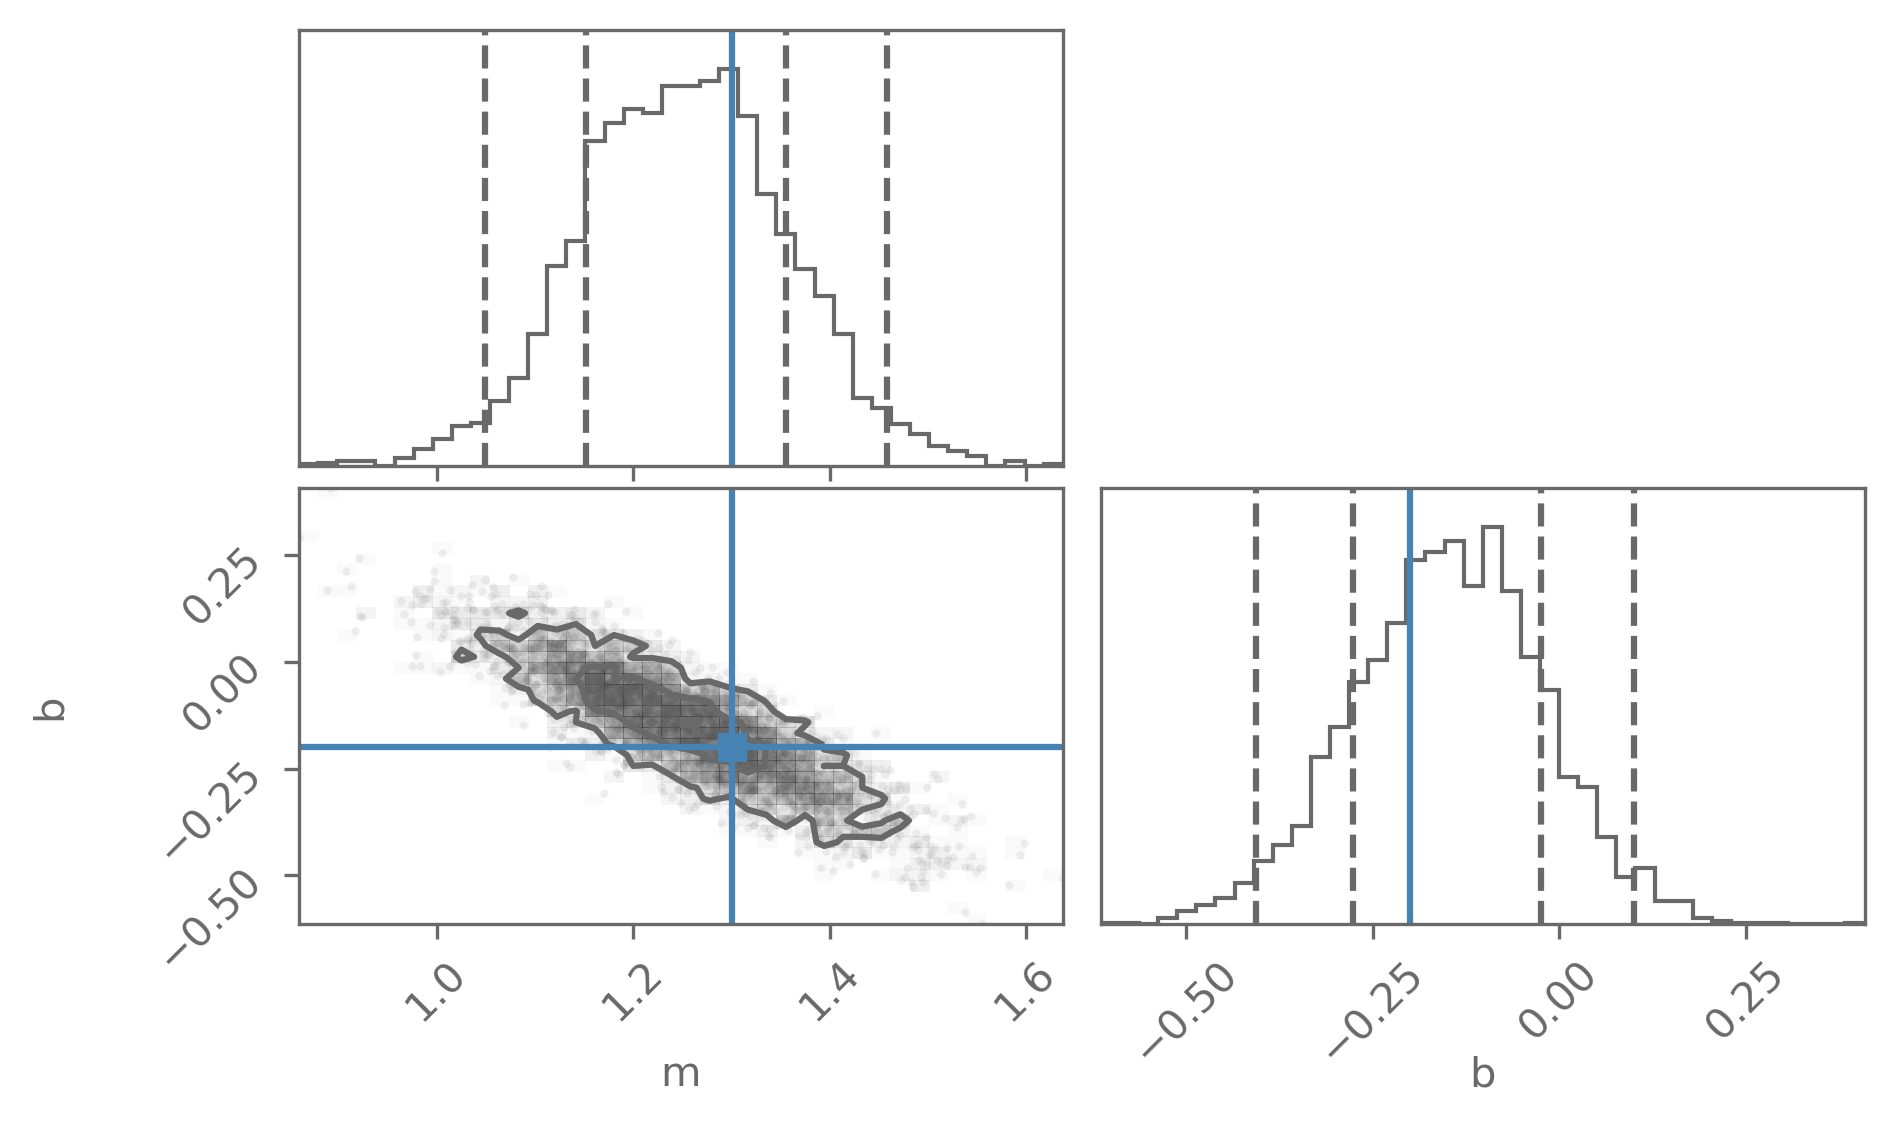

In [157]:
fig

In [94]:
np.mean(chain, axis=0), np.cov(chain.T)

(array([ 1.25407765, -0.14829877]),
 array([[ 0.01069977, -0.01124795],
        [-0.01124795,  0.016245  ]]))

## Making predictions

First, let us look at the uncertainty of the model, given the posterior. 

For this we compute samples of the translated posterior predictive distribution.

In [164]:
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
model_predictive = np.array(
    [model(*sample, x) for sample in chain_samples]
)

model_quantiles = np.quantile(
    model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

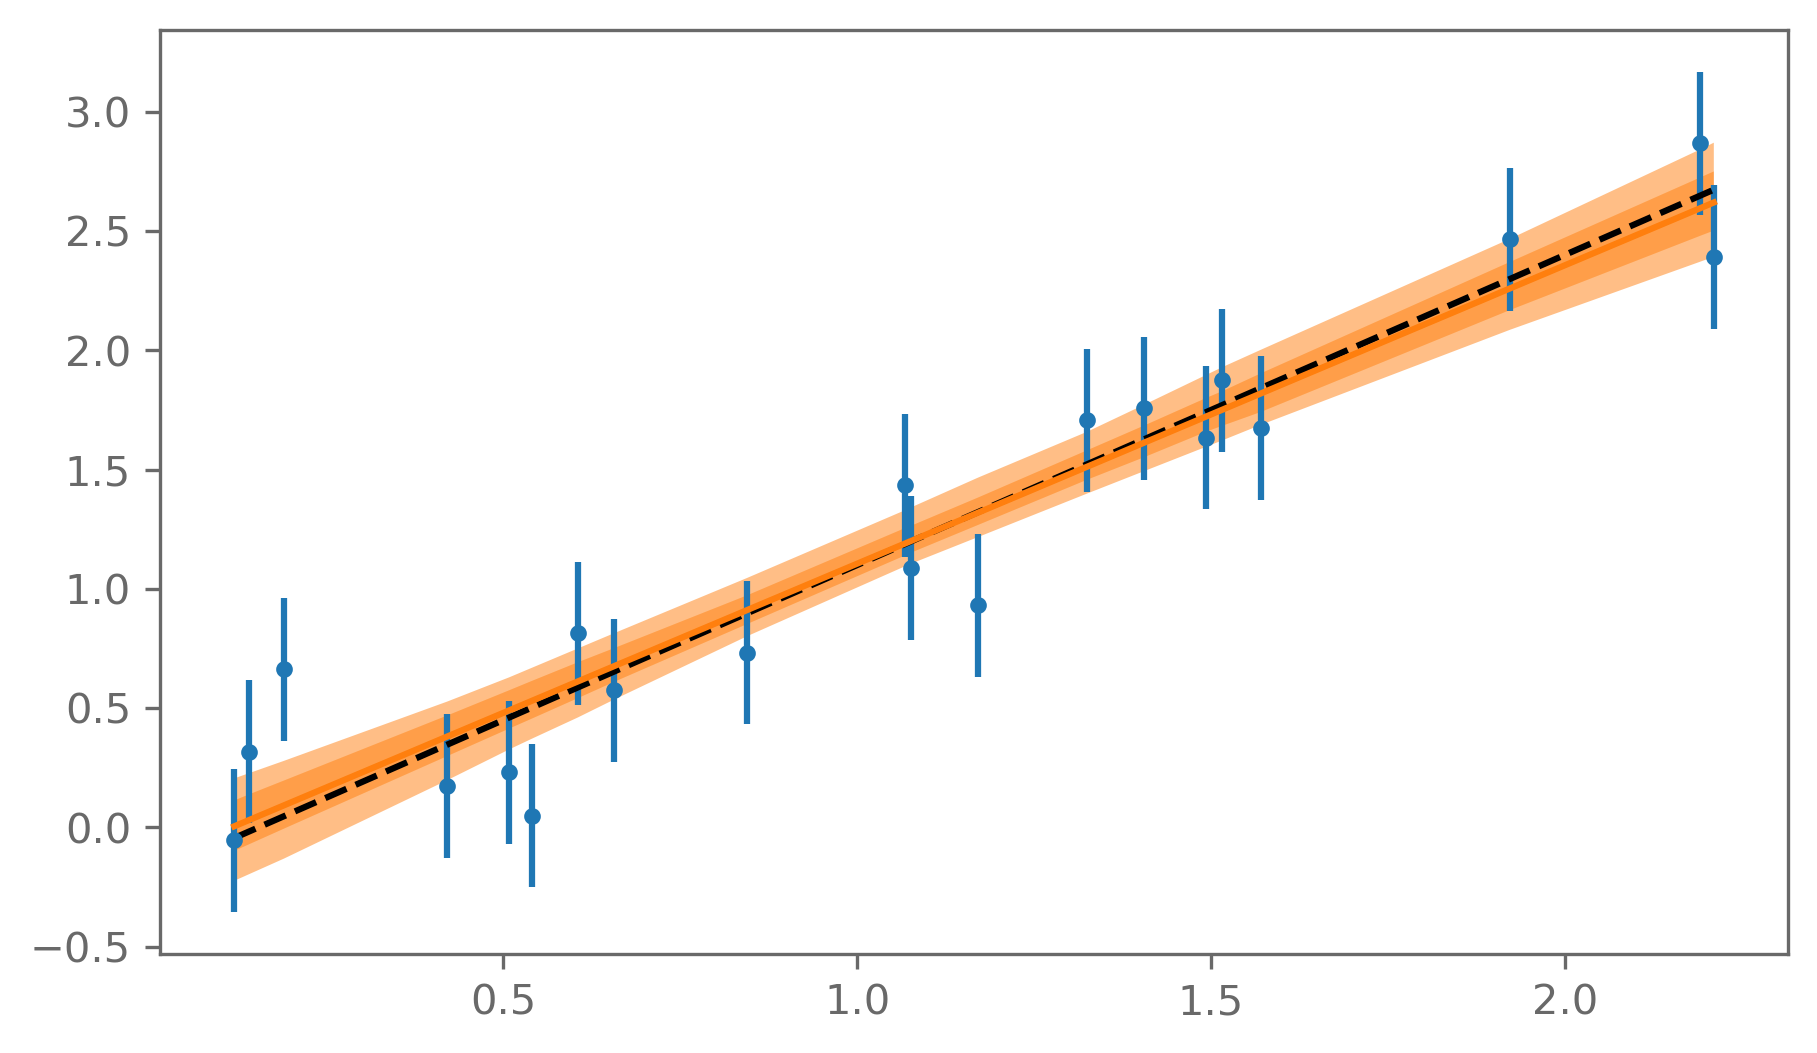

In [160]:
plt.errorbar(x, y, y_err, fmt=".")
plt.plot(x, model(m_true, b_true, x), c="k", ls="--")

plt.plot(x, model(m_MAP, b_MAP, x), c="C1")
plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1")
plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1");

We can also see if the observed data agree with what the posterior predictive distribution says new data would look like.

In [165]:
posterior_predictive = \
    model_predictive + sigma_y*np.random.normal(size=(200,len(x)))

posterior_predictive_quantiles = np.quantile(
    posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

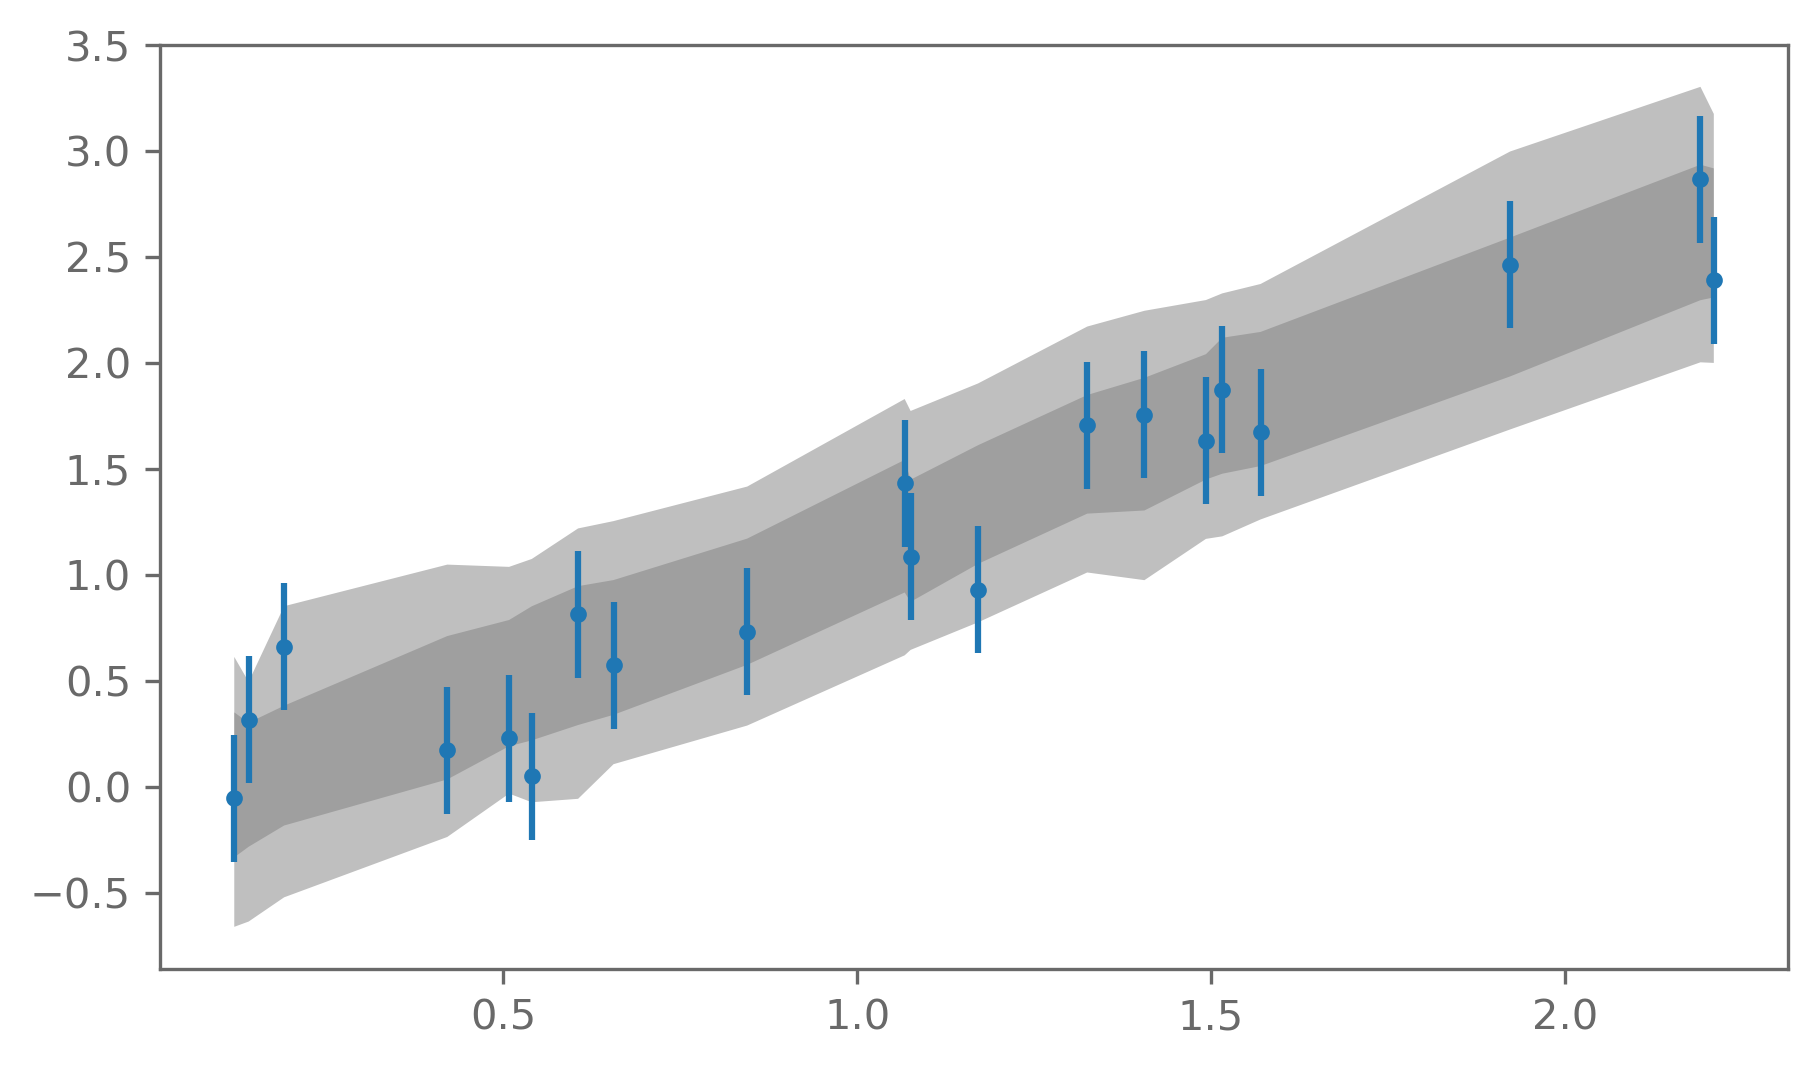

In [163]:

plt.errorbar(x, y, y_err, fmt=".")
plt.fill_between(x, posterior_predictive_quantiles[0], posterior_predictive_quantiles[-1], facecolor="grey", alpha=0.5)
plt.fill_between(x, posterior_predictive_quantiles[1], posterior_predictive_quantiles[-2], facecolor="grey", alpha=0.5)

# Exercise

- Implement your own version of the line-fitting procedure, using the same data.
- Now try it with the data in `lessons/data/linear_fits/data_1.txt`
    - First plot the data. What has changed?
    - Try the same model and likelihood on the new data.

- Instead use the actual likelihood of the data:
\begin{align}
    \mu(x) &= mx + b \\
    \sigma(x) &= \sigma_y + f\mu(x)^2 \\
    y_i&\sim\Norm(\mu(x_i),\sigma(x_i)^2)
\end{align}